# Deterministic Model of Blood Alcohol Concentration (BAC)
This is a deterministic compartmental model tracking an individual's blood alcohol concentration (BAC) over time. 
Contributions: Stephanie Lapadat proposed the pathway of alcohol within the model while Romina Mahinpei implemented the model using Python

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

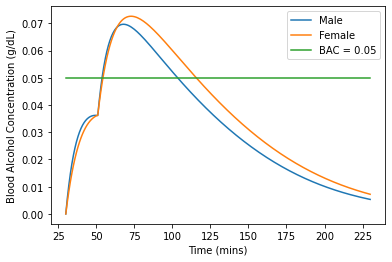

Peak BAC for male: 0.0697 g/dL
Occrs at 68 min
Peak BAC for female: 0.0726 g/dL
Occrs at 73 min

Time for male to drop below reference BAC: 58 min
Time for female to drop below reference BAC: 69 min

Maximum rate of decrease in BAC for male: 0.000663 g/dL/min
Occrs at 93 min
Maximum rate of decrease in BAC for female: 0.000647 g/dL/min
Occrs at 104 min

Average rate of decrease in BAC for male: 0.000419 g/dL/min
Average rate of decrease in BAC for female: 0.00045 g/dL/min

Maximum rate of increase in BAC for male: 0.005676 g/dL/min
Occrs at 31 min
Maximum rate of increase in BAC for female: 0.004567 g/dL/min
Occrs at 52 min

Average rate of increase in BAC for male: 0.001734 g/dL/min
Average rate of increase in BAC for female: 0.00172 g/dL/min



In [2]:
# define baseline parameters
BAC = 0.05         # reference BAC level to include on graph (g/dL)
lag = 30           # lag between the time when alcohol is consumed and when absorption begins (min)

Vd_m = 0.69        # volume of distribution of alcohol for male (L/kg)  
Vd_f = 0.63        # volume of distribution of alcohol for female (L/kg)  

Vmax_m = 0.0078    # male max elimination rate from liver  (g/L/min)
Vmax_f = 0.0080    # female max elimination rate from liver  (g/L/min)

kmax_m = 0.380     # Michaelis-Menten constant of elimination from liver for male(g/L)
kmax_f = 0.405     # Michaelis-Menten constant of elimination from liver for female (g/L)

k1_m = 0.1175      # absorption rate constant of small intestine for male (1/min)   
k1_f = 0.0827      # absorption rate constant of small intestine for female (1/min)  

k2 = 0.0003        # elimination rate constant from sweat (1/min)
k3 = 0.0010        # elimination rate constant from kidney (1/min)
k4 = 0.0027        # elimination rate constant from lungs (1/min)

# define changing parameters            
W = 60             # weight of individual (kg)
I_tot = 40         # total intake of alcohol (g)
n = 2             # number of intakes (including initial) between which total intake is equally divided
T = 20             # wait time between each intake, if applicable (min)

# calculate parameters dependent on changing parameters         
I = I_tot/n        # calculate amount of alcohol consumed at each intake (g) 
intake_times = []  # initialize array that will include additional intake times                                    
counter = 1
while counter < n: # add additional intake times to array
    intake_times.append(counter*T)
    counter = counter + 1

# initialize starting conditions
t = 0              # initial time of absorption (min)
S_m = I/(W*Vd_m)   # initial concentration of alcohol in male's small intestine (g/L)  
S_f = I/(W*Vd_f)   # initial concentration of alcohol in female's small intestine (g/L) 
B_m = 0            # initial concentration of alcohol in male's blood (g/L) 
B_f = 0            # initial concentration of alcohol in female's blood (g/L) 

# initialize arrays for compartments and passing time
time = []          # for passing time 
Ssim_m = []        # for concentration of alcohol in male's stomach
Ssim_f = []        # for concentration of alcohol in female's stomach
Bsim_m = []        # for concentration of alcohol in male's blood
Bsim_f = []        # for concentration of alcohol in female's blood
tsim_m = []        # for calculating time for BAC to drop below reference
tsim_f = []        # for calculating time for BAC to drop below reference
dBsim_m = []       # for calculating rate of change in BAC for male
dBsim_f = []       # for calculating rate of change in BAC for female

# append initial values to arrays
time.append(t+lag) # account for the lag between when alcohol is consumed and when it is absorbed 
Ssim_m.append(S_m) 
Ssim_f.append(S_f)
Bsim_m.append(B_m)
Bsim_f.append(B_f)
dBsim_m.append(0)
dBsim_f.append(0)

while t < 200:
    # calculate rate of change of alcohol concentration in stomach
    if t in intake_times:  
        dS_m = -k1_m*S_m + I/(W*Vd_m) 
        dS_f = -k1_f*S_f + I/(W*Vd_f)
    else: 
        dS_m = -k1_m*S_m  
        dS_f = -k1_f*S_f   
    
    # calculate rate of change of alcohol concentration in blood
    dB_m = k1_m*S_m - Vmax_m*B_m/(kmax_m+B_m) - (k2+k3+k4)*B_m
    dB_f = k1_f*S_f - Vmax_f*B_f/(kmax_f+B_f) - (k2+k3+k4)*B_f

    # add updated rates of change of alcohol concentration in blood 
    # convert units from g/L to g/dL (most common unit for BAC)
    dBsim_m.append(dB_m/10)
    dBsim_f.append(dB_f/10)
    
    # calculate updated alcohol concentrations in compartments
    t = t+1
    S_m = S_m + dS_m
    S_f = S_f + dS_f
    B_m = B_m + dB_m
    B_f = B_f + dB_f
    
    # add updated alcohol concentration in compartments to arrays
    Ssim_m.append(S_m)
    Ssim_f.append(S_f)
    Bsim_m.append(B_m/10) 
    Bsim_f.append(B_f/10) 
    time.append(t+lag)
    
    # store times when reference BAC reached 
    if round(B_m/10, 2) == BAC:
        tsim_m.append(t+lag)
    if round(B_f/10, 2) == BAC:
        tsim_f.append(t+lag)

# calculate index of max BAC in arrays
index_m = Bsim_m.index(max(Bsim_m)) 
index_f = Bsim_f.index(max(Bsim_f))

# calculate average rate of decrease in BAC for male
x1_m = np.array(time[index_m:len(time)])
y1_m = np.array(Bsim_m[index_m:len(Bsim_m)])
m1_m, b1_m = np.polyfit(x1_m,y1_m,1)

# calculate average rate of increase in BAC for female
x1_f = np.array(time[index_f:len(time)]) 
y1_f = np.array(Bsim_f[index_f:len(Bsim_f)])
m1_f, b1_f = np.polyfit(x1_f,y1_f,1)

# calculate average rate of increase in BAC for male
x2_m = np.array(time[0:index_m]) 
y2_m = np.array(Bsim_m[0:index_m])
m2_m, b2_m = np.polyfit(x2_m,y2_m,1)

# calculate average rate of increase in BAC for female
x2_f = np.array(time[0:index_f]) 
y2_f = np.array(Bsim_f[0:index_f])
m2_f, b2_f = np.polyfit(x2_f,y2_f,1)

# plot blood alcohol concentration curves for male and female 
plt.figure 
plt.plot(time, Bsim_m, label="Male")
plt.plot(time, Bsim_f, label="Female")
plt.plot([(0+lag),(t+lag)],[BAC,BAC],label='BAC = ' + str(BAC))
plt.xlabel("Time (mins)")
plt.ylabel("Blood Alcohol Concentration (g/dL)")
plt.legend()
plt.show() 

# display peak BAC, average rate of change in BAC, max rate of change in BAC (for both males and females)
print("Peak BAC for male: " + "{:.4f}".format(max(Bsim_m)) + " g/dL")
print("Occrs at " + str(time[index_m]) + " min")
print("Peak BAC for female: " + "{:.4f}".format(max(Bsim_f)) + " g/dL")
print("Occrs at " + str(time[index_f]) + " min")
print()
print("Time for male to drop below reference BAC: " + str((max(tsim_m) - (min(tsim_m)))) + " min")
print("Time for female to drop below reference BAC: " + str((max(tsim_f) - (min(tsim_f)))) + " min")
print()
print("Maximum rate of decrease in BAC for male: " + str(round(abs((min(dBsim_m))), 6)) + " g/dL/min")
print("Occrs at " + str(time[dBsim_m.index(min(dBsim_m))]) + " min")
print("Maximum rate of decrease in BAC for female: " + str(round(abs((min(dBsim_f))), 6)) + " g/dL/min")
print("Occrs at " + str(time[dBsim_f.index(min(dBsim_f))]) + " min")
print()
print("Average rate of decrease in BAC for male: " + str(round(abs(m1_m), 6))+ " g/dL/min")
print("Average rate of decrease in BAC for female: " + str(round(abs(m1_f), 6))+ " g/dL/min")
print()
print("Maximum rate of increase in BAC for male: " + str(round(max(dBsim_m), 6)) + " g/dL/min")
print("Occrs at " + str(time[dBsim_m.index(max(dBsim_m))]) + " min")
print("Maximum rate of increase in BAC for female: " + str(round(max(dBsim_f), 6)) + " g/dL/min")
print("Occrs at " + str(time[dBsim_f.index(max(dBsim_f))]) + " min")
print()
print("Average rate of increase in BAC for male: " + str(round(abs(m2_m), 6))+ " g/dL/min")
print("Average rate of increase in BAC for female: " + str(round(abs(m2_f), 6))+ " g/dL/min")
print()